In [1]:
import pandas as pd
import os
from math import *
import re
from datetime import datetime, date, time, timedelta
import fix_yahoo_finance as yf
import matplotlib.pyplot as plt
import numpy as np
from time import sleep
from MPT_utils import * 
import cvxpy as cvx
import numpy as np
from scipy import stats


In [2]:
#universe = ['spy','ark'] 
universe = ['spy']
#universe = ['ark']

#variables for data download
hist_window = 100 #for historical pricing
date_fmt = '%Y-%m-%d'
start_date = datetime.now() - timedelta(hist_window)
start_date = start_date.strftime(date_fmt)
sleep_time = 5
lb = 55; min_gross=0.5; max_gross=1; min_w=0; max_w=0.05 # default optimization vars
refresh_pricing = False
min_weight=-0.01 ## minimo peso para portafolio filtrado 

config = {'spy' : {
            'benchmark': 'spy',
            'skiprows': 1,
            'columns': ['Symbol', 'Company Name']},
        'ark' : {
            'benchmark': 'ark' ,
            'skiprows': 0,
            'columns': ['ticker','company']}}

pricing_path = "./pricing/"
component_path = "./sector_components/"

In [3]:
# 1. Sector Components

# In[3]:

### 1. Sector components:
# de donde se extrae esta info, con que frecuencia se actualiza?

## 1.1 descargar componentes del server:

## 1.2 cargar los sector componentes para cada benchmark, cargar cada ETF sector para cada benchmark
# y cada company para cada ETF sectior y limpiarlos

companies_universe= pd.DataFrame({}) ### contiene todas las compañias del etf sector para cada benchmark
sector_etf = {}   ### contiene cada etf sector para cada benchmark
ticker_map= {}    ### contiene todas las compañias para cada etf sector 

for k in universe:
    #print(config[k])
    companies,benchmark_etf_map,sector_tickers_map=load_companies(benchmark=config[k]['benchmark'],skiprows=config[k]['skiprows'],columns=config[k]['columns']) ## companies del benchmark spy
    print("Companies loaded:",config[k]['benchmark'], companies.shape)
    companies_universe=companies_universe.append(companies)
    sector_etf.update(benchmark_etf_map)
    ticker_map.update(sector_tickers_map)


loaded: xlb
loaded: xle
loaded: xlf
loaded: xli
loaded: xlk
loaded: xlp
loaded: xlre
loaded: xlu
loaded: xlv
loaded: xly
Companies loaded: spy (505, 3)


In [4]:
# 2. Pricing            : Contiene la informacion historica de precios de cada uno de los componentes

## 2.1 descargar componentes del server:

if refresh_pricing==True:
    ### refresh components
    etfs=[ [i,j,ticker_map[j]] for i in universe for j in sector_etf[i] ]
    for i in etfs:
        get_pricing(output_name=pricing_path+i[0]+"/"+i[1]+"-hold-pricing.csv",
        ticker_list=i[2],start_date=start_date)
    ## refresh etf sectors 
    sectors=[[i,sector_etf[i]] for i in universe]
    for j in sectors:
        get_pricing(output_name=pricing_path+j[0]+"/"+j[0]+'-sectors.csv', 
        ticker_list=j[1], start_date=start_date)
    # refresh benchmarks
    benchmarks=[i for i in universe]
    #benchmarks
    for j in benchmarks:
        print(j)
        get_pricing(output_name=pricing_path+ j +'/'+j+'.csv', ticker_list=j, start_date=start_date)


In [5]:

### consol_px contiene los precios historicos de cada compañia
consol_px=load_consol_px(universe)
consol_px=consol_px[sorted(consol_px.columns.tolist())]
print("consol_px"+str(consol_px.shape))
### crear consol_px 

    
# #### Limpiar las compañias que tienen valores nulos en los ultimos 3 dias y valores nulos en toda su serie
consol_px,cols=clean_nas(consol_px) ## limpia de aquellos valores que no tienen valores en su serie o que por alguna razon tienen NAN en los ultimos dias
print("se limpio consol_px"+str(consol_px.shape))
print("se borraron:")
print(cols)


# Removing tickers for M&A targets and diff class shares of same co.
remove_tickers = ['CSRA', 'DPS', 'UAA', 'DISCK', 'JUNO', 'XL', 'WELL', 'BKNG', 'SNI','EVGN'] # example: two M&A targets, diff share classes...
remove = list(set(remove_tickers).intersection(consol_px.columns.tolist()))
if len(remove) > 0:
    consol_px.drop(remove, axis=1, inplace=True)

consol_px.to_csv("consol_mpt_opt.csv")
print("consol_px final: "+str(consol_px.shape))

spy
consol_px(69, 505)
se limpio consol_px(69, 501)
se borraron:
BF.B     69
BRK.B    69
BKNG     55
SNI       6
dtype: int64
consol_px final: (69, 495)


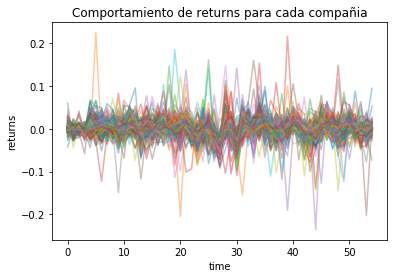

In [6]:
# 3. Optimizacion

px_portion = consol_px[-abs(hist_window):].copy() ## tomar los ultimos hist_window rows de la tabla de precios
px_portion= px_portion.sort_index().pct_change(); px_portion.iloc[0] = 0 ## calcular returns
return_vec =px_portion.loc[:px_portion.tail(1).index[0]].tail(lb)#.dropna()

### grafico de comportamientos de returns
plot_returns(return_vec)


In [229]:
## optimizacion para una gamma dada
def get_opt(return_vec,max_sum,lmax,max_w,min_w,gamma_i):
    weights =np.asarray([1/len(return_vec.columns) for _ in range(len(return_vec.columns))])
    mu = return_vec.mean().values ## vector de return mean
    n = len(mu) ## numero de compañias
    name = return_vec.mean().index.values.tolist() ## nombre de las compañias
    Sigma =  return_vec.cov().values  ## covarianza de los retornos
    w = cvx.Variable(n) ## variable a optimizar
    gamma = cvx.Parameter(sign='positive') ## aversion al riesgo
    ret = mu.T*w   # returns
    risk = cvx.quad_form(w, Sigma)
    # Portfolio optimization with leverage limit.
    prob = cvx.Problem(cvx.Maximize(ret - gamma*risk), 
               [cvx.sum_entries(w) > max_sum,  ## problema con exposicion de a los mas 1.5
                cvx.norm(w, 1) <= lmax,w<=max_w,w>=min_w])
    gamma.value=gamma_i
    prob.solve()
    if prob.status == 'optimal':
        weights=[j[0] for j in w.value.tolist()]
        return sqrt(risk.value),ret.value,weights,ret.value/sqrt(risk.value),name,Sigma,mu
    else:
        return 0,0,[0],0,name,Sigma,mu
    #prob = cvx.Problem(cvx.Minimize(gamma*risk-ret), 
    #              [cvx.norm(w, 1) <= 1.3, cvx.sum_entries(w) >.7,-.05<=w,w<=.05])
                #cvx.norm(w, 1) <= 1,w<0])

    #return sqrt(risk.value),ret.value,weights,ret.value/sqrt(risk.value),name,Sigma,mu
#prob.is_dcp()

### optimizacion de la gamma
def get_gamma_opt(return_vec,max_sum,lmax,max_w,min_w):
    SAMPLES = 100
    w_ = [0]*SAMPLES
    risk_data = np.zeros(SAMPLES)
    ret_data = np.zeros(SAMPLES)
    sharpe = np.zeros(SAMPLES)
    gamma_vals = np.logspace(-2, 3, num=SAMPLES)
    for i in range(SAMPLES):
        risk_o,ret_o,w_o,sharpe_o,name,Sigma,mu=get_opt(return_vec,max_sum,lmax,max_w,min_w,gamma_vals[i])
        risk_data[i] = risk_o
        ret_data[i]= ret_o
        w_[i]=w_o
        sharpe[i]=sharpe_o
    optimo = sharpe.argmax()
    return risk_data,ret_data,w_,gamma_vals,sharpe,name,Sigma,mu,optimo

def get_subportfolio(w_,optimo,name):
    ## escoger subportafolio
    short_position1=[j for j in w_[optimo] if j<-.01]
    short_position2=[j for j in short_position1 if j>-.05]
    long_position1=[j for j in w_[optimo] if j>.01]
    long_position2=[j for j in long_position1 if j<.05]
    weights_all=short_position2+long_position2
    short_names1=[w_[optimo].index(j) for j in short_position2]
    long_names1=[w_[optimo].index(j) for j in long_position2]
    short_names2=[name[i] for i in short_names1]
    long_names2=[name[i] for i in long_names1]
    all_positions=short_names2+long_names2
    #all_positions=sorted(all_positions)
    return weights_all,all_positions

def get_metrics(px_portion,all_positions,weights_all):
    ## calcular las metricas de risk , return y sharpe
    returns_subport = px_portion[all_positions]
    mu_subportfolio = returns_subport.mean()
    cov_matrix_subportfolio = returns_subport.cov()
    weights_subportfolio = np.array(weights_all).reshape(len(weights_all),1)
    n_dias = returns_subport.shape[0]
    return_subportfolio = (np.dot(mu_subportfolio.values, weights_subportfolio)*n_dias)
    #print("return: "+str(return_subportfolio[0]))
    risk_subportfolio = (np.sqrt(np.dot(weights_subportfolio.T, np.dot(cov_matrix_subportfolio.values, weights_subportfolio))))*(np.sqrt(n_dias))
    #print("risk: "+str(risk_subportfolio[0][0]))
    sharpe_subportfolio = return_subportfolio/risk_subportfolio
    #print("sharpe: "+str(sharpe_subportfolio[0][0]))
    return return_subportfolio[0],risk_subportfolio[0][0],sharpe_subportfolio[0][0],returns_subport,weights_subportfolio

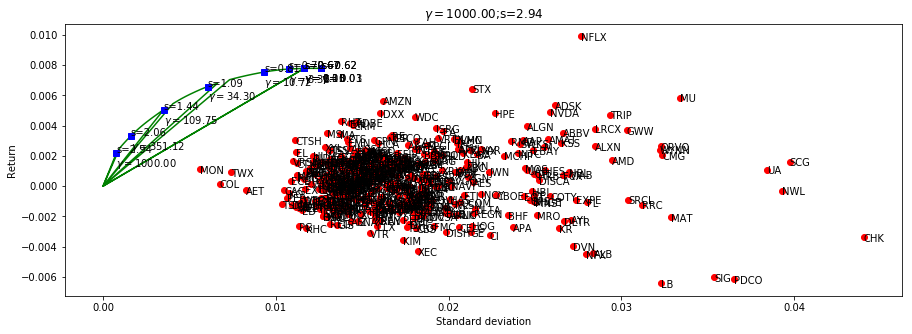

In [230]:
## obtiene el gamma idx del gamma optimo y su historial de valores para seleccionar el optimo
risk_data,ret_data,w_,gamma_vals,sharpe,name,Sigma,mu,optimo=get_gamma_opt(return_vec,.7,1.7,.05,-.05)
### pinta la optimizacion encontrada
plot_Optimization(risk_data,ret_data,gamma_vals,sharpe,name,Sigma,mu)
### del portafolio con la gamma optima forma un subportafolio y obtiene los pesos y los nombres 
weights_all,all_positions=get_subportfolio(w_,optimo,name)
## Obtiene las metricas del subportafolio
returns,risk,sharpe,returns_subport,weights_subportfolio=get_metrics(px_portion,all_positions,weights_all)

In [231]:
returns,risk,sharpe

(0.099346905320616283, 0.017602933127482071, 5.64376996726266)

In [232]:
recommend =pd.DataFrame(weights_all,index=all_positions,columns=["w"]) ### formar portafolio
stats.describe(weights_all)

DescribeResult(nobs=51, minmax=(-0.049999999993521171, 0.049999999997325323), mean=0.012741301775109824, variance=0.001108901261072273, skewness=-0.4622276332239008, kurtosis=-1.0989768631126302)

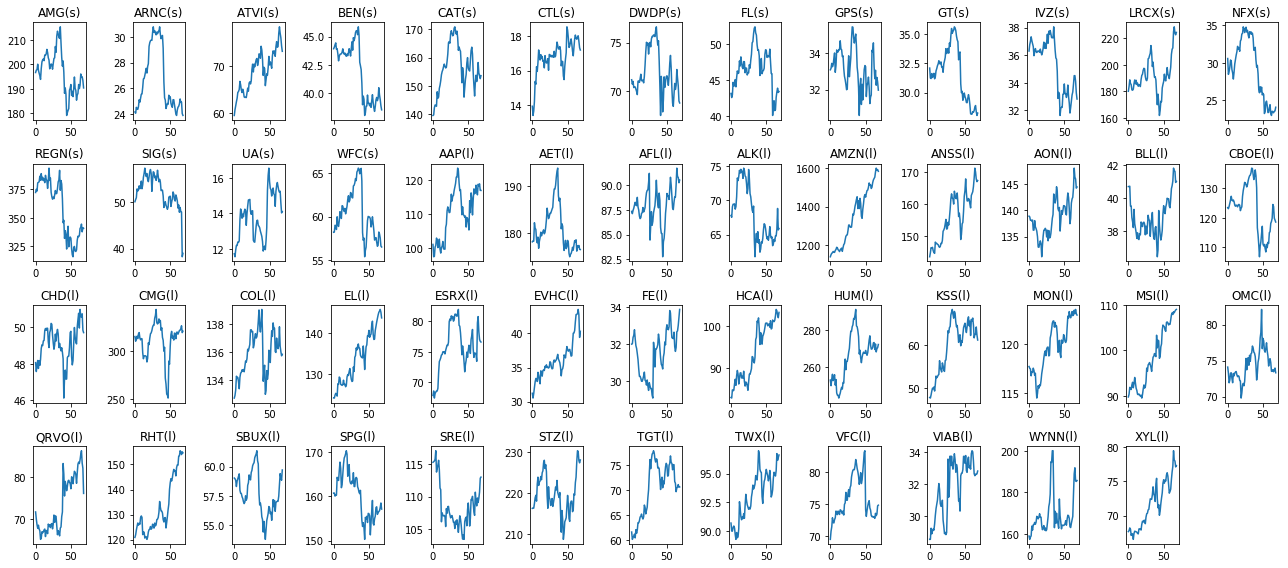

In [214]:
j=1
n=ceil(len(recommend.index.tolist())/4)
plt_all=recommend.index.tolist()
fig = plt.figure(figsize=(18,8))
fig.subplots_adjust(left=0.2, wspace=1) 
for i in plt_all:
    ax=fig.add_subplot(4,n,j) 
    fig.tight_layout()
    if recommend.loc[i][0]>0:
        p="(l)"
    else:
        p="(s)"
    ax.set_title(i+p)
    ax.plot(consol_px[i].values)
    j=j+1
    #print(i)

plt.show()

In [224]:
sum(recommend[recommend.w>0].values),sum(recommend[recommend.w<0].values),sum(recommend.values)

(array([ 1.14188895]), array([-0.49208256]), array([ 0.64980639]))

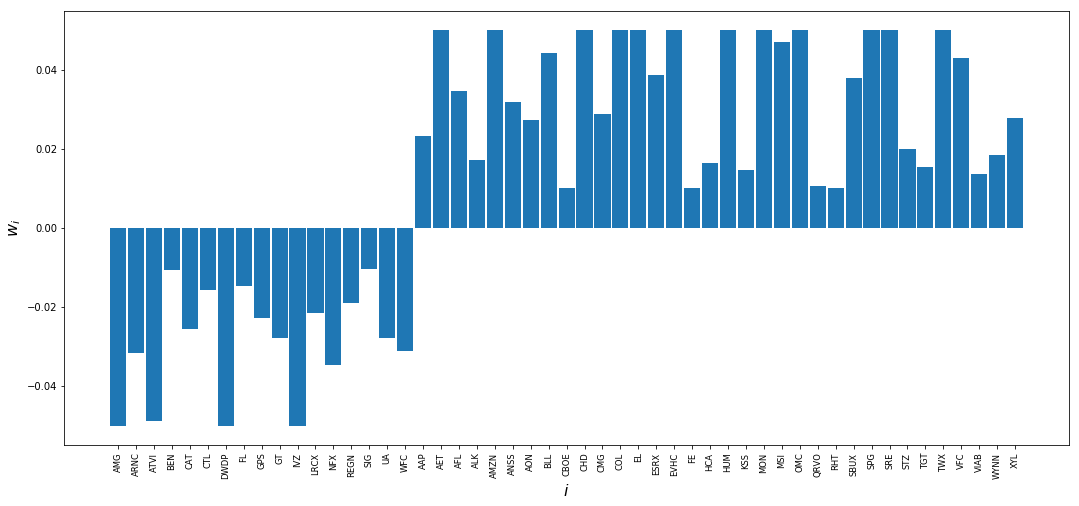

In [225]:
plt.figure(figsize=(18,8))
plt.bar( range(len(plt_all)),recommend["w"].tolist(), width = 0.9)
#plt.xticks(recommend.index.tolist())
plt.xticks(rotation=90)
plt.ylabel(r"$w_i$", fontsize=16)
plt.xlabel(r"$i$", fontsize=16)
plt.xticks(range(len(recommend.index.tolist())), recommend.index.tolist(), size='small',fontsize=14)
# Set ticks labels for x-axis
plt.show()

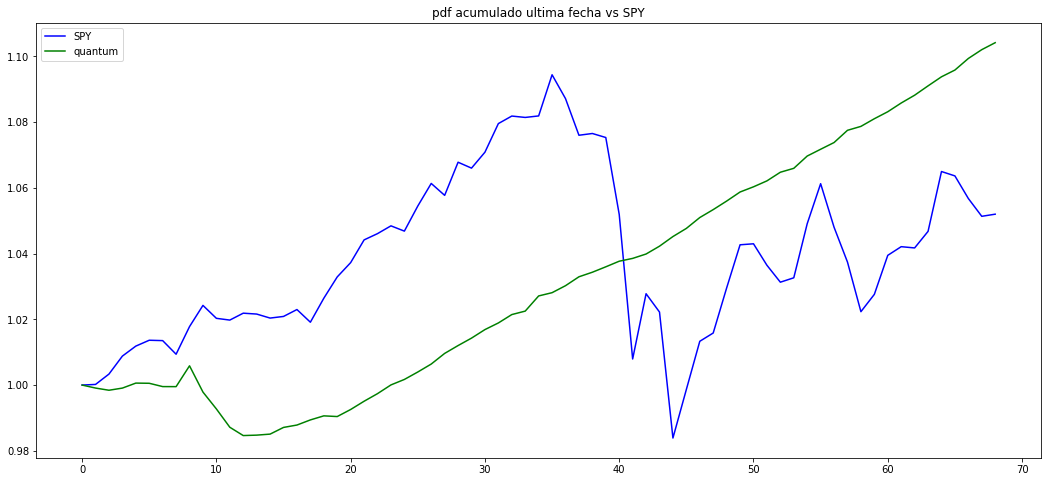

In [233]:
def calc_port_performance(arr, weights):
    return np.cumprod(np.sum(arr * weights, axis=0) + 1)

def compound(df):
    pct = df.pct_change() + 1
    pct.iloc[0] = 1
    return pct.cumprod()

port_perf=calc_port_performance(np.array(returns_subport.values.T),weights_subportfolio.tolist())
#port_perf=np.cumprod(np.sum(np.multiply(returns_subport.values, hist_allocs12.values),axis=1)+1)
pdf = pd.DataFrame(port_perf, index=returns_subport.index, columns=["Quantum"])
pdf
px_spy = pd.read_csv('./pricing/SPY/SPY.csv',index_col=["Date"])
#px_spy
#len(returns_subport.index)
#returns_subport.T.values
idx = px_spy.iloc[-(len(pdf.index)+1):].index
idx
idx_px_spy = compound(px_spy.loc[idx])
fig = plt.figure(figsize=(18,8))
plt.plot(idx_px_spy.values,"b-")
plt.plot(pdf.values,"g-")
plt.title("pdf acumulado ultima fecha vs SPY")
plt.legend(["SPY","quantum"])
plt.show()
#plot_two_series(idx_px_spy, pdf, 'SPY', 'Quantum', 'Date', 'Index Return', 'Optimized vs. Benchmark')

#len(np.array(returns_subport.T.values)*weights_subportfolio.tolist())
#pdf.values
#dx_px_spy.index.tolist()

In [234]:
pdf

,Quantum
Date,
2017-12-05,1.000000
2017-12-06,0.999088
2017-12-07,0.998422
2017-12-08,0.999077
2017-12-11,1.000597
2017-12-12,1.000542
2017-12-13,0.999535
2017-12-14,0.999520
2017-12-15,1.005860


In [235]:

# Outputs for trade execution
px = consol_px[recommend.index][-lb:]
date = pd.to_datetime(px[-1:].index[0])#.strftime(date_fmt)

trading_cols = ['Price', 'Allocation', 'Dollar Value', 'Shares']
trading_df = pd.DataFrame([], index=recommend.index, columns=trading_cols)

port_bal = 231000; 
alloc = recommend["w"].values
pvalue = (port_bal * alloc)
shares = (port_bal * alloc) / px[-1:]
#shares.apply(lambda x: round(x, 6)).T.sort_index()

#trading_df['Company'] = pd.DataFrame(recommend.index)
trading_df['Price'] = px[-1:].T
trading_df['Allocation'] = recommend['w']
trading_df['Dollar Value'] = trading_df['Allocation'] * port_bal
trading_df['Shares'] = trading_df['Dollar Value'] / trading_df['Price']

print("Time Window: {}, Lookback: {}, MinGross: {}, MaxGross: {}, MinWeight: {}, MaxWeight: {}".format(hist_window, lb, min_gross, max_gross, -.05, .05))
print("Ann. Ret: {1:.3f}, Risk: {1:.3f} Sharpe: {2:.3f}".format(return_subportfolio[0], risk_subportfolio[0][0], sharpe_subportfolio[0][0]))
print("Date: {0}, Total Invested: {1:.2f}, Total Allocation: {2:.2f}%".format(date, trading_df['Dollar Value'].sum(), trading_df['Allocation'].sum() * 100))

#trading_df = trading_df.astype({'Dollar Value':np.int, 'Shares':np.int})
trading_df.sort_index()

Time Window: 100, Lookback: 55, MinGross: 0.5, MaxGross: 1, MinWeight: -0.05, MaxWeight: 0.05
Ann. Ret: 0.025, Risk: 0.025 Sharpe: 5.353
Date: 2018-03-15 00:00:00, Total Invested: 150105.28, Total Allocation: 64.98%


,Price,Allocation,Dollar Value,Shares
AAP,117.050003,0.023331,5389.442979,46.043937
AET,176.580002,0.050000,11549.999998,65.409445
AFL,90.470001,0.034732,8023.134848,88.682820
ALK,65.879997,0.017232,3980.692963,60.423393
AMG,190.389999,-0.050000,-11549.999993,-60.664951
AMZN,1581.880005,0.050000,11549.999998,7.301439
ANSS,167.301407,0.031755,7335.428161,43.845586
AON,144.440002,0.027248,6294.389329,43.577882
ARNC,23.915001,-0.031738,-7331.416396,-306.561409
ATVI,73.059998,-0.048801,-11273.002038,-154.297870


In [196]:


#SAMPLES = 1000; gamma_vals = np.logspace(-2, 3, num=SAMPLES)
dx_net=np.arange(0, 1, 0.1)
hist_allocs_net=[]
for i in dx_net:
    print(1+i)
    as_of_idx = pd.to_datetime(consol_px.index).to_period(freq='W-WED').drop_duplicates().to_timestamp().to_native_types()
    hist_allocs = pd.DataFrame([], index=consol_px.index,columns=consol_px.columns)
    for d in as_of_idx: 
        subset = consol_px.loc[:d]
        if len(subset)>5:
            print(d)
            subset_portion = subset[-abs(hist_window):].copy() ## tomar los ultimos hist_window rows de la tabla de precios
            subset_portion= subset_portion.sort_index().pct_change(); subset_portion.iloc[0] = 0 ## calcular returns
            sub_return_vec =subset_portion.loc[:subset_portion.tail(1).index[0]].tail(lb)#.dropna()
            ### obtiene el gamma idx del gamma optimo y su historial de valores para seleccionar el optimo:
            risk_data,ret_data,w_,gamma_vals,sharpe,name,Sigma,mu,optimo=get_gamma_opt(sub_return_vec,.7,1+i,.05,-.05)
            ### del portafolio con la gamma optima forma un subportafolio y obtiene los pesos y los nombres 
            weights_all,all_positions=get_subportfolio(w_,optimo,name)
            ## Obtiene las metricas del subportafolio
            returns,risk,sharpe=get_metrics(px_portion,all_positions,weights_all)
            aux=pd.DataFrame(np.array(weights_all).reshape(1,len(weights_all)),columns=all_positions,index=[d])
            hist_allocs = hist_allocs.combine_first(aux)
    hist_allocs_net.append(hist_allocs)
        
    
    
#hist_allocs

1.0
2017-12-14
2017-12-21
2017-12-28
2018-01-04
2018-01-11
2018-01-18
2018-01-25
2018-02-01
2018-02-08
2018-02-15
2018-02-22
2018-03-01
2018-03-08
2018-03-15
1.1
2017-12-14
2017-12-21
2017-12-28
2018-01-04
2018-01-11
2018-01-18
2018-01-25
2018-02-01
2018-02-08
2018-02-15
2018-02-22
2018-03-01
2018-03-08
2018-03-15
1.2
2017-12-14
2017-12-21
2017-12-28
2018-01-04
2018-01-11
2018-01-18
2018-01-25
2018-02-01
2018-02-08
2018-02-15
2018-02-22
2018-03-01
2018-03-08
2018-03-15
1.3
2017-12-14
2017-12-21
2017-12-28
2018-01-04
2018-01-11
2018-01-18
2018-01-25
2018-02-01
2018-02-08
2018-02-15
2018-02-22
2018-03-01
2018-03-08
2018-03-15
1.4
2017-12-14
2017-12-21
2017-12-28
2018-01-04
2018-01-11
2018-01-18
2018-01-25
2018-02-01
2018-02-08
2018-02-15
2018-02-22
2018-03-01
2018-03-08
2018-03-15
1.5
2017-12-14
2017-12-21
2017-12-28
2018-01-04
2018-01-11
2018-01-18
2018-01-25
2018-02-01
2018-02-08
2018-02-15
2018-02-22
2018-03-01
2018-03-08
2018-03-15
1.6
2017-12-14
2017-12-21
2017-12-28
2018-01-04
2018

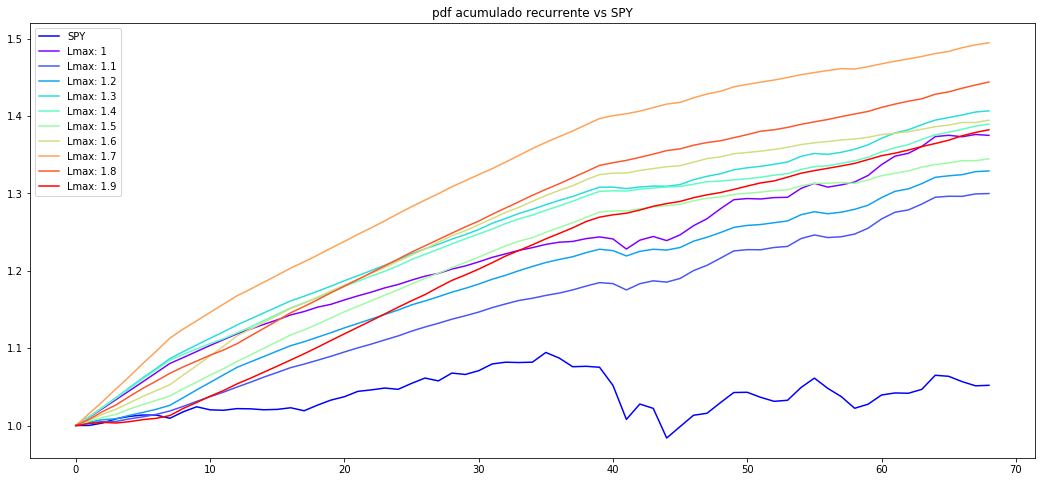

In [236]:
#hist_allocs1 = hist_allocs.loc[hist_allocs.dropna(how="all").index].replace(0, np.nan)#.fillna(method='ffill')
#hist_allocs1.replace(np.nan, 0, inplace=True)
#hist_allocs1
legen=["SPY"]
px_spy = pd.read_csv('./pricing/SPY/SPY.csv',index_col=["Date"])
#px_spy
#len(returns_subport.index)
#returns_subport.T.values
idx = px_spy.iloc[-(len(pdf.index)+1):].index
idx_px_spy = compound(px_spy.loc[idx])

fig = plt.figure(figsize=(18,8))
plt.plot(idx_px_spy.values,"b-")
plt.title("pdf acumulado recurrente vs SPY")
return_vec2=consol_px.sort_index().pct_change(); return_vec2.iloc[0] = 0 ## calcular returns
var=1
from matplotlib.pyplot import cm 
color=cm.rainbow(np.linspace(0,1,10))
k=0
for j in hist_allocs_net:
    aux=j.copy()
    hist_allocs1=aux.combine_first(aux.loc[aux.dropna(how="all").index].fillna(0))
    hist_allocs12=hist_allocs1.fillna(method='bfill')
    port_perf=np.cumprod(np.sum(np.multiply(return_vec2.values, hist_allocs12.values),axis=1)+1)
    #port_perf=calc_port_performance(return_vec2.values,hist_allocs12.values)
    #len(port_perf)
    pdf = pd.DataFrame(port_perf, index=return_vec2.index, columns=["Quantum"])
    pdf
    legen=legen+["Lmax: "+str(round(var,2))]
    var=var+.1
    #plt.plot(pdf.values,"g-")
    plt.plot(pdf.values,c=color[k])
    k=k+1

plt.legend(legen)
plt.show()